# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy.stats import ks_2samp

In [53]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url,
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada.
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [55]:
#função que faz análise bivariada entre uma variável explicativa categórica e uma variável resposta binária.
def analise_bivariada(df: pd.DataFrame, var_explicativa: str, var_resposta: str):
    tab = pd.crosstab(df[var_explicativa], df[var_resposta], margins=True, margins_name="Total")
    tab['Prob'] = round(tab[1] / tab['Total'] ,2)
    tab['Odd'] = round(tab[1] / tab[0] ,2)
    min_chance = tab['Odd'].argmin()
    tab['OddRatio'] = round(tab['Odd'] / tab.iloc[min_chance, -1] ,2)
    tab['Logito'] = np.log(tab['Odd'])
    tab['WOE'] = np.log(tab['OddRatio'])
    return tab

In [56]:
analise_bivariada(df, 'sex', 'flag_doente')

flag_doente,0,1,Total,Prob,Odd,OddRatio,Logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.26,0.35,1.00,-1.049822,0.000000
1.0,92,114,206,0.55,1.24,3.54,0.215111,1.264127
Total,164,139,303,0.46,0.85,2.43,-0.162519,0.887891


In [57]:
analise_bivariada(df, 'fbs', 'flag_doente')

flag_doente,0,1,Total,Prob,Odd,OddRatio,Logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.45,0.83,1.00,-0.186330,0.000000
1.0,23,22,45,0.49,0.96,1.16,-0.040822,0.148420
Total,164,139,303,0.46,0.85,1.02,-0.162519,0.019803


In [58]:
analise_bivariada(df, 'exang', 'flag_doente')

flag_doente,0,1,Total,Prob,Odd,OddRatio,Logito,WOE
exang,,,,,,,,
0.0,141,63,204,0.31,0.45,1.00,-0.798508,0.000000
1.0,23,76,99,0.77,3.30,7.33,1.193922,1.991976
Total,164,139,303,0.46,0.85,1.89,-0.162519,0.636577


A variável "exang" parece ter uma maior capacidade de discriminação, pois apresenta a maior diferença nos índices em relação à variável resposta.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [59]:
#função que faz análise bivariada entre uma variável explicativa contínua e uma variável resposta binária.
def analise_bivariada_cont(df: pd.DataFrame, var_explicativa: str, var_resposta: str, qtd_qubras: int=5):
    df = df.copy()
    df[var_explicativa] = pd.qcut(df[var_explicativa], qtd_qubras)
    tab = pd.crosstab(df[var_explicativa], df[var_resposta], margins=True, margins_name="Total")
    tab['Prob'] = round(tab[1] / tab['Total'] ,2)
    tab['Odd'] = round(tab[1] / tab[0] ,2)
    min_chance = tab['Odd'].argmin()
    tab['OddRatio'] = round(tab['Odd'] / tab.iloc[min_chance, -1] ,2)
    tab['Logito'] = np.log(tab['Odd'])
    tab['WOE'] = np.log(tab['OddRatio'])
    return tab

In [60]:
analise_bivariada_cont(df, 'thalach', 'flag_doente')

flag_doente,0,1,Total,Prob,Odd,OddRatio,Logito,WOE
thalach,,,,,,,,
"(70.999, 130.0]",16,47,63,0.75,2.94,15.47,1.078410,2.738903
"(130.0, 146.0]",20,39,59,0.66,1.95,10.26,0.667829,2.328253
"(146.0, 159.0]",39,23,62,0.37,0.59,3.11,-0.527633,1.134623
"(159.0, 170.0]",41,21,62,0.34,0.51,2.68,-0.673345,0.985817
"(170.0, 202.0]",48,9,57,0.16,0.19,1.00,-1.660731,0.000000
Total,164,139,303,0.46,0.85,4.47,-0.162519,1.497388


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [61]:
#contruindo um modelo de regressao com as variaveis sex + cp + trestbps + age.
reglog = smf.logit("flag_doente ~ sex + cp + trestbps + age"
                   , data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.2605
Time:                        18:17:18   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

SEX: A log-odds de uma pessoa estar doente é aproximadamente 1.8021 vezes maior para um indivíduo do sexo masculino em comparação com o sexo feminino.

CP: A log-odds de uma pessoa estar doente é aproximadamente 1.1403 vezes maior para uma determinada categoria de dor no peito em comparação com outra categoria.

TRESTBPS: A log-odds de uma pessoa estar doente aumenta em 0.0214 unidades para cada unidade de aumento na pressão sanguínea em repouso.

AGE: A log-odds de uma pessoa estar doente aumenta em 0.0582 unidades para cada ano de aumento na idade.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [62]:
# Prevendo valores e adicionando-os ao DataFrame
df['pred'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,pred
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.196041
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.928431
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.846558
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.276207
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.024768


In [63]:
#dividir os valores da coluna 'pred' em 5 grupos
cat_pred = pd.qcut(df['pred'], 5)
cat_pred.value_counts()

(0.0119, 0.146]    61
(0.349, 0.575]     61
(0.772, 0.928]     61
(0.146, 0.349]     60
(0.575, 0.772]     60
Name: pred, dtype: int64

In [64]:
#calcular a média da coluna pred em cada grupo e renomeia essa coluna como media_pred.
group_pred = df.groupby(cat_pred)
calib = group_pred[['pred']].mean().rename(columns={'pred': 'media_pred'})
calib

,media_pred
pred,
"(0.0119, 0.146]",0.076255
"(0.146, 0.349]",0.249060
"(0.349, 0.575]",0.457982
"(0.575, 0.772]",0.673059
"(0.772, 0.928]",0.837449


In [65]:
# Calcula a média da coluna 'flag_doente' e atribui à coluna 'pct_doente' em calib
calib['pct_doente'] = group_pred[['flag_doente']].mean()
calib

,media_pred,pct_doente
pred,,
"(0.0119, 0.146]",0.076255,0.098361
"(0.146, 0.349]",0.249060,0.183333
"(0.349, 0.575]",0.457982,0.491803
"(0.575, 0.772]",0.673059,0.683333
"(0.772, 0.928]",0.837449,0.836066


                 pct_pred  pct_doente
pred                                 
(0.0119, 0.146]  0.076255    0.098361
(0.146, 0.349]   0.249060    0.183333
(0.349, 0.575]   0.457982    0.491803
(0.575, 0.772]   0.673059    0.683333
(0.772, 0.928]   0.837449    0.836066


(None, None)

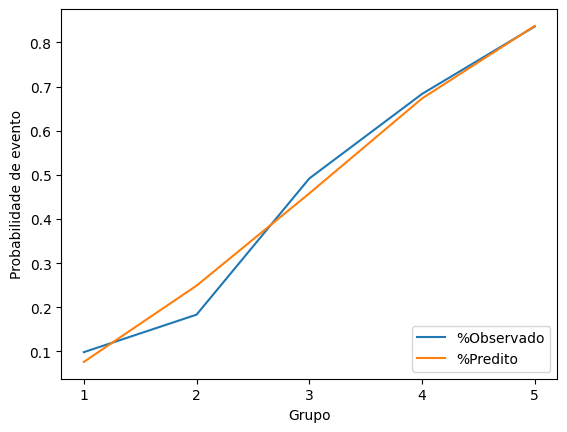

In [66]:
#Define uma funcao, "grafico_calib", e plota um gráfico de linha comparando as percentagens reais e previstas de eventos
def grafico_calib(pct_real, pct_prev):

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax = pct_real.plot(label='%Observado')
    ax = pct_prev.plot(label='%Predito')

    ticks = ax.set_xticks([0, 1, 2, 3, 4])
    labels = ax.set_xticklabels([1, 2, 3, 4, 5])
    ax.legend(loc="lower right")
    ax.set_ylabel('Probabilidade de evento')
    ax.set_xlabel('Grupo')
#Função avalia a calibração de um modelo de classificação
def avalia_calib(df, pred):

    cat_pred = pd.qcut(df[pred], 5)
    cat_pred.value_counts()
    group_pred = df.groupby(cat_pred)
    calib = group_pred[[pred]].mean().rename(columns={'pred': 'pct_pred'})
    calib['pct_doente'] = group_pred[['flag_doente']].mean()
    return print(calib), grafico_calib(calib['pct_doente'], calib['pct_pred'])

avalia_calib(df, 'pred')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [67]:
#função que calcula acurácia do modelo,Curva ROC,Gini e Kolmogorov-Smirnov (KS)
def avalia_disc(df, var_resp, pred):

    acc = accuracy_score(df[var_resp], df[pred] >.5) # É necessário colocar o maior que .5 para que ele gere uma lista booleana e seja possível de comparar com o 0 e 1 da variável resposta
    fpr, tpr, threshold = roc_curve(df[var_resp], df[pred])
    auc_ = auc(fpr, tpr)
    gini = 2*auc_ -1
    ks = ks_2samp(df.loc[df[var_resp] == 1, pred], df.loc[df[var_resp] == 0, pred]).statistic

    print(f'Acurácia: {acc}')
    print(f'Gini: {gini}')
    print(f'KS: {ks}')

avalia_disc(df, 'flag_doente', 'pred')

Acurácia: 0.7788778877887789
Gini: 0.6622214423583084
KS: 0.5840498333040884


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [68]:
#Ajustando o modelo de regressão logística
reglog2 = smf.logit("flag_doente ~ sex + chol + age + restecg + trestbps + cp + exang + ca"
                   , data=df).fit()

reglog2.summary()

Optimization terminated successfully.
         Current function value: 0.400430
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                           11
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.4194
Time:                        18:17:19   Log-Likelihood:                -121.33
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 9.458e-32
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.3652      1.993     -5.201      0.000     -14.272      -6.459
ca[T.1.0]      1.6829      0.411      4.091      0.000       0.877       2.489
ca[T.2.0]      2.8134      0.610      4.609      0.000       1.617       4.010
ca[T.3.0]      2.4207      0.728      3.327      0.001       0.995       3.847
ca[T.?]       -0.5198      1.504     -0.345      0.730      -3.468       2.429
sex            1.8556      0.407      4.555      0.000       1.057       2.654
chol           0.0036      0.003      1.061      0.289      -0.003       0.010
age            0.0093      0.021      0.448      0.654      -0.031       0.050
restecg        0.2560      0.166      1.538      0.124      -0.070       0.582
trestbps       0.0242      0.010      2.432      0.015       0.005       0.044
cp             0.8377      0.186      4.495      0.000       0.472       1.203
exang          1.5966      0.369      4.325      0.000       0.873       2.320
==============================================================================
"""

In [69]:
#Calculando as probabilidades previstas
df['pred'] = reglog2.predict(df)

                   pct_pred  pct_doente
pred                                   
(0.00588, 0.0799]  0.042092    0.032787
(0.0799, 0.267]    0.162332    0.200000
(0.267, 0.584]     0.409066    0.377049
(0.584, 0.877]     0.725830    0.700000
(0.877, 0.993]     0.953928    0.983607


(None, None)

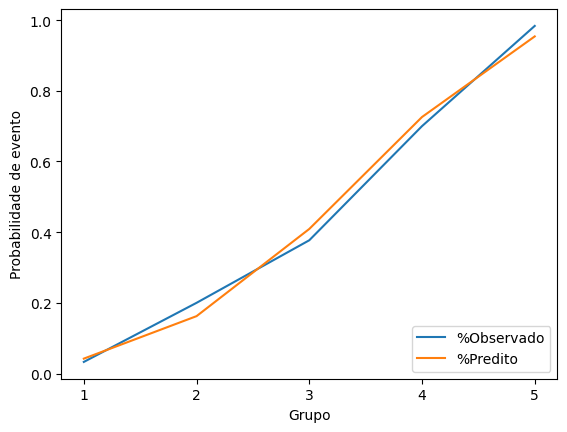

In [70]:
#Avaliando a calibração
avalia_calib(df, 'pred')

In [71]:
# métricas de desempenho do modelo melhorado
avalia_disc(df, 'flag_doente', 'pred')

Acurácia: 0.8151815181518152
Gini: 0.7900508861203719
KS: 0.6406387085453589


Pseudo R-squared: O Pseudo R-squared é 0.4194, o que sugere que o modelo explica uma quantidade substancial da variabilidade nos dados de resposta.

P-valores dos Coeficientes: A maioria dos coeficientes das variáveis incluídas é estatisticamente significativa, pois seus p-valores são muito pequenos (< 0.05). Isso sugere que essas variáveis têm um impacto significativo na probabilidade de um paciente estar doente.

Em geral, com base nos resultados fornecidos, parece que a inclusão das variáveis adicionais melhorou significativamente o modelo de regressão logística em comparação com um modelo mais simples sem variáveis independentes.